
                              Preparing to collect information from pages..
The page from which the collection of information begins: 
 https://cian.ru/cat.php?engine_version=2&p=1&with_neighbors=0&region=1&deal_type=sale&offer_type=flat&room1=1&room2=1&room3=1

 1 | 1 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 28. Progress ratio: 20 %. Average price: 739 428 481 rub
 2 | 2 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 56. Progress ratio: 40 %. Average price: 812 507 617 rub
 3 | 3 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 83. Progress ratio: 60 %. Average price: 855 195 303 rub
 4 | 4 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 92. Progress ratio: 66 %. Average price: 862 422 832 rub
 5 | 5 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>

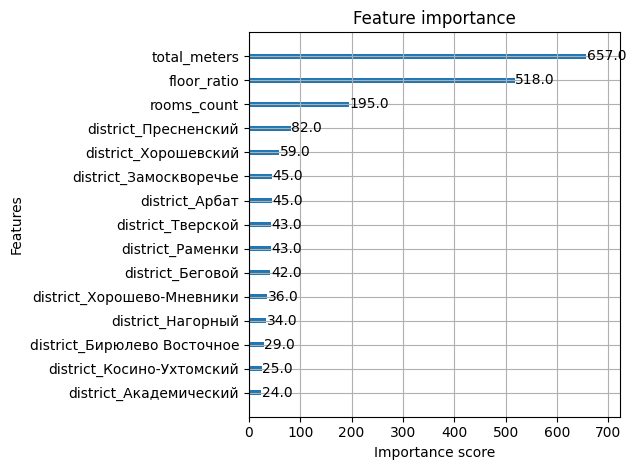

In [ ]:
from cianparser import CianParser
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 🔍 Парсинг
parser = CianParser(location="Москва")
data = parser.get_flats(
    deal_type="sale",
    rooms=(1, 2, 3),
    with_saving_csv=False,
    additional_settings={"start_page": 1, "end_page": 5}
)
df = pd.DataFrame(data)
df.to_csv("moscow_flats.csv", index=False)

print("📋 Доступные столбцы:", df.columns.tolist())

price_col = "price"
area_col_candidates = ["area_total", "total_area", "square", "size", "area"]
area_col = next((col for col in area_col_candidates if col in df.columns), None)

if price_col not in df.columns:
    raise ValueError("❌ В данных отсутствует колонка 'price'.")

df = df.drop_duplicates()
df = df.dropna(subset=[price_col])
df[price_col] = df[price_col].astype(float)

if area_col:
    df = df.dropna(subset=[area_col])
    df[area_col] = df[area_col].astype(float)
    df = df[(df[area_col] > 15) & (df[area_col] < 200)]
    df["price_per_m2"] = df[price_col] / df[area_col]

df = df[(df[price_col] > 1_000_000) & (df[price_col] < 100_000_000)]

df["near_metro"] = df["metro_minutes"].apply(lambda x: x < 10 if pd.notnull(x) else False) if "metro_minutes" in df.columns else False
df["has_renovation"] = df["renovation"].notnull().astype(int) if "renovation" in df.columns else 0
df["floor_ratio"] = df["floor"] / df["floors_count"] if "floor" in df.columns and "floors_count" in df.columns else 0
df["has_balcony"] = df["has_balcony"].astype(int) if "has_balcony" in df.columns else 0

if "metro" in df.columns:
    df["metro"] = df["metro"].fillna("unknown")
if "address" in df.columns:
    df["district"] = df["address"].str.extract(r"район\s([^,]+)")

categorical_cols = [col for col in ["metro", "district"] if col in df.columns]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
y = df[price_col]
drop_cols = ["description", "address", "phones", "seller", "added_at", "floor", "floors_count"]
X = df.drop(columns=[price_col] + drop_cols, errors='ignore')
X = X.select_dtypes(include=["number", "bool"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE: {rmse:,.0f} руб.")
print(f"📈 R²: {r2:.4f}")

# 🔍 Визуализация важности
xgb.plot_importance(model, max_num_features=15)
plt.tight_layout()
plt.show()
